In [1]:
from datasets import load_dataset
from transformers import EarlyStoppingCallback, IntervalStrategy

train_ds = load_dataset("imagefolder", data_dir="data/original/urbansound8k", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/8733 [00:00<?, ?it/s]

Using custom data configuration default-dc4b097253cef5b2
Found cached dataset imagefolder (/home/ubuntu/.cache/huggingface/datasets/imagefolder/default-dc4b097253cef5b2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


5500 2620 612


In [2]:
# !pip install datasets
# !pip install Pillow
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install -U scikit-learn
# !pip install tensorboard

In [3]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [4]:
import json

with open('data/label2id.json') as f:
    label2id = json.load(f)

with open('data/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [5]:

from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


In [6]:
feature_extractor.size

{'height': 224, 'width': 224}

In [7]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [8]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [9]:
val_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>],
 'classID': [5, 9],
 'class': ['engine_idling', 'street_music'],
 'pixel_values': [tensor([[[-0.9216, -0.9137, -0.9137,  ..., -0.5529, -0.6000, -0.7255],
           [-0.8039, -0.7882, -0.7804,  ..., -0.4353, -0.4824, -0.6078],
           [-0.3882, -0.3412, -0.3020,  ...,  0.0039, -0.0431, -0.1608],
           ...,
           [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922],
           [ 0.9922,  0.9922,  0.9922,  ...,  0.9843,  0.9843,  0.9843],
           [ 0.9765,  0.9765,  0.9765,  ...,  0.9686,  0.9686,  0.9686]],
  
          [[-0.9373, -0.9294, -0.9294,  ..., -0.8745, -0.8745, -0.8667],
           [-0.9216, -0.9137, -0.9059,  ..., -0.8431, -0.8431, -0.8431],
           [-0.8588, -0.8431, -0.8275,  ..., -0.7098, -0.7255, -0.7725],
           ...,
           [ 0.4902,  0.4588,  0.4118,  ...,  0.4588,  0.4667,  0.4902],
           

In [10]:

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [11]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [24]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "air_conditioner",
    "1": "car_horn",
    "2": "children_playing",
    "3": "dog_bark",
    "4": "drilling",
    "5": "engine_idling",
    "6": "gun_shot",
    "7": "jackhammer",
    "8": "siren",
    "9": "street_music"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "air_conditioner": 0,
    "car_horn": 1,
    "children_playing": 2,
    "dog_bark": 3,
    "drilling": 4,
    "engine_idling": 5,
    "gun_shot": 6,
    "jackhammer": 7,
    "siren": 8,
    "s

In [26]:
# Changing the number of attention heads from 12 -> 10 -- Dropping 2 heads
model.config.patch_size = 32

In [27]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "air_conditioner",
    "1": "car_horn",
    "2": "children_playing",
    "3": "dog_bark",
    "4": "drilling",
    "5": "engine_idling",
    "6": "gun_shot",
    "7": "jackhammer",
    "8": "siren",
    "9": "street_music"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "air_conditioner": 0,
    "car_horn": 1,
    "children_playing": 2,
    "dog_bark": 3,
    "drilling": 4,
    "engine_idling": 5,
    "gun_shot": 6,
    "jackhammer": 7,
    "siren": 8,
    "street_music": 9
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 32,
  "qkv_bias": true,
  "transformers_vers

In [28]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/ubuntu/.cache/huggingface/hub


In [29]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-urbansound8k-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [30]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [31]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [32]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [33]:

# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2196), started 0:04:18 ago. (Use '!kill 2196' to kill it.)

In [34]:
trainer.train()

/home/ubuntu/mlenv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5500
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 27500
  Number of trainable parameters = 85806346


Epoch,Training Loss,Validation Loss,Accuracy
1,1.457900,0.892811,0.800654
2,0.879400,0.587645,0.862745
3,0.670500,0.503247,0.861111
4,0.578800,0.412820,0.885621
5,0.502900,0.406577,0.874183
6,0.441200,0.339699,0.905229
7,0.411900,0.305576,0.911765
8,0.379400,0.343415,0.905229
9,0.366000,0.270495,0.924837
10,0.306900,0.324961,0.916667


***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-urbansound8k-10/checkpoint-550
Configuration saved in test-urbansound8k-10/checkpoint-550/config.json
Model weights saved in test-urbansound8k-10/checkpoint-550/pytorch_model.bin
Image processor saved in test-urbansound8k-10/checkpoint-550/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-urbansound8k-10/checkpoint-1100
Configuration saved in test-urbansound8k-10/checkpoint-1100/config.json
Model weights saved in test-urbansound8k-10/checkpoint-1100/pytorch_model.bin
Image processor saved in test-urbansound8k-10/checkpoint-1100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-urbansound8k-10/checkpoint-1650
Configuration saved in test-urbansound8k-10/checkpoint-1650/config.json
Model weights saved in test-urbansound8k-10/checkpoint-1650

TrainOutput(global_step=6600, training_loss=0.5272911008199056, metrics={'train_runtime': 2739.901, 'train_samples_per_second': 100.369, 'train_steps_per_second': 10.037, 'total_flos': 5.114838029672448e+18, 'train_loss': 0.5272911008199056, 'epoch': 12.0})

In [35]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2620
  Batch size = 4


In [36]:
print(outputs.metrics)

{'test_loss': 0.239968940615654, 'test_accuracy': 0.9324427480916031, 'test_runtime': 43.3331, 'test_samples_per_second': 60.462, 'test_steps_per_second': 15.115}


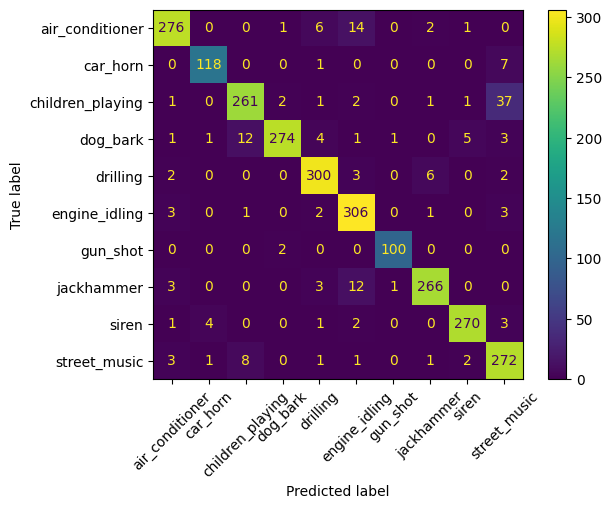

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [39]:
model.save_pretrained("/home/ubuntu/models/AudioViT_Ablation_PatchSize_32")

Configuration saved in /home/ubuntu/models/AudioViT_Ablation_PatchSize_32/config.json
Model weights saved in /home/ubuntu/models/AudioViT_Ablation_PatchSize_32/pytorch_model.bin
